# Description

The notebook contains checks that compare the prod system output vs that of the prod simulation run ensuring basic sanity.

# Imports

In [49]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import logging
import os

import pandas as pd

import core.config as cconfig
import core.finance.target_position_df_processing as cftpdp
import core.plotting as coplotti
import dataflow.core as dtfcore
import dataflow.model as dtfmod
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import oms as oms
import reconciliation as reconcil

In [51]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO  # Git
  branch_name='CmampTask7204_Allow_to_pass_a_notebook_config_through_a_file'
  hash='e2e740b0e'
  # Last commits:
    *   e2e740b0e Vlad     Merge branch 'master' into CmampTask7204_Allow_to_pass_a_notebook_config_through_a_file (56 minutes ago) Thu Apr 4 16:16:01 2024  (HEAD -> CmampTask7204_Allow_to_pass_a_notebook_config_through_a_file, origin/CmampTask7204_Allow_to_pass_a_notebook_config_through_a_file)
    |\  
    | * e5ae16a90 Sonaal   CmampTask7703_Gather_Information_on_Binance_Perpetual_Contract_Status (#7773) (   2 hours ago) Thu Apr 4 15:34:04 2024  (origin/master, origin/HEAD, origin/CmampTask7800_Remove_delisted_symbols_from_binance_universe, master)
    | * d9cae3d68 Shayan   Switch to new SMTP (#7799)                                        (   4 hours ago) Thu Apr 4 12:45:27 2024  (origin/CmTask7640_Expose_price_col_to_config_in_the_Master_execution_analysis_notebook)
# Machine info
  system=Linux
  node name=a5c2d8c3da0d
  release=5.15.0-1052-aws
  version=#

# Build the reconciliation config

In [52]:
# When running manually, specify the path to the config to load config from file,
# for e.g., `.../reconciliation_notebook/fast/result_0/config.pkl`.
config_file_name = None
config = cconfig.get_notebook_config(config_file_name)
if config is None:
    _LOG.info("Using hardwired config")
    # Specify the config directly when running the notebook manually.
    # Below is just an example.
    dst_root_dir = "/shared_data/ecs/preprod/prod_reconciliation/"
    dag_builder_ctor_as_str = (
        "dataflow_orange.pipelines.C3.C3a_pipeline_tmp.C3a_DagBuilder_tmp"
    )
    start_timestamp_as_str = "20240330_131000"
    end_timestamp_as_str = "20240331_130500"
    run_mode = "paper_trading"
    mode = "scheduled"
    set_config_values = None
    config_list = reconcil.build_reconciliation_configs(
        dst_root_dir,
        dag_builder_ctor_as_str,
        start_timestamp_as_str,
        end_timestamp_as_str,
        run_mode,
        mode,
        set_config_values=set_config_values,
    )
    config = config_list[0]
print(config)

INFO  Using config from the pickle file: /shared_data/CmTask7204_2/C3a/paper_trading/20240319_131000.20240320_130500/reconciliation_notebook/fast/result_0/config.pkl
WARNING Running inside Docker on the dev server, thus replacing path with the mapping: {'/data/shared': '/shared_data', '/data/shared2': '/shared_data2'}
WARNING Running inside Docker on the dev server, thus replacing path with the mapping: {'/data/shared': '/shared_data', '/data/shared2': '/shared_data2'}
WARNING Running inside Docker on the dev server, thus replacing path with the mapping: {'/data/shared': '/shared_data', '/data/shared2': '/shared_data2'}
WARNING Running inside Docker on the dev server, thus replacing path with the mapping: {'/data/shared': '/shared_data', '/data/shared2': '/shared_data2'}
WARNING Running inside Docker on the dev server, thus replacing path with the mapping: {'/data/shared': '/shared_data', '/data/shared2': '/shared_data2'}
WARNING Running inside Docker on the dev server, thus replacing 

# Specify data to load

In [53]:
# The dict points to `system_log_dir` for different experiments.
system_log_path_dict = dict(config["system_log_path"].to_dict())

In [54]:
# This dict points to `system_log_dir/dag/node_io/node_io.data` for different experiments.
data_type = "dag_data"
dag_path_dict = reconcil.get_system_log_paths(
    system_log_path_dict, data_type, only_warning=True
)
dag_path_dict

{'prod': '/shared_data/CmTask7204_2/C3a/paper_trading/20240319_131000.20240320_130500/prod/system_log_dir.scheduled/dag/node_io/node_io.data',
 'sim': '/shared_data/CmTask7204_2/C3a/paper_trading/20240319_131000.20240320_130500/simulation/system_log_dir.scheduled/dag/node_io/node_io.data'}

In [55]:
# This dict points to `system_log_dir/process_forecasts/portfolio` for different experiments.
data_type = "portfolio"
portfolio_path_dict = reconcil.get_system_log_paths(
    system_log_path_dict, data_type
)
portfolio_path_dict

{'prod': '/shared_data/CmTask7204_2/C3a/paper_trading/20240319_131000.20240320_130500/prod/system_log_dir.scheduled/process_forecasts/portfolio',
 'sim': '/shared_data/CmTask7204_2/C3a/paper_trading/20240319_131000.20240320_130500/simulation/system_log_dir.scheduled/process_forecasts/portfolio'}

In [56]:
# This dict points to `system_log_dir/process_forecasts/orders` for different experiments.
data_type = "orders"
orders_path_dict = reconcil.get_system_log_paths(system_log_path_dict, data_type)
orders_path_dict

{'prod': '/shared_data/CmTask7204_2/C3a/paper_trading/20240319_131000.20240320_130500/prod/system_log_dir.scheduled/process_forecasts/orders',
 'sim': '/shared_data/CmTask7204_2/C3a/paper_trading/20240319_131000.20240320_130500/simulation/system_log_dir.scheduled/process_forecasts/orders'}

In [57]:
# TODO(gp): Load the TCA data for crypto.
if config["meta"]["run_tca"]:
    tca_csv = os.path.join(
        root_dir, config["meta"]["date_str"], "tca/sau1_tca.csv"
    )
    hdbg.dassert_file_exists(tca_csv)

# Configs

## Load and display configs

In [58]:
configs = reconcil.load_config_dict_from_pickle(system_log_path_dict)
# TODO(Dan): Deprecate after switch to updated config logs CmTask6627.
hdbg.dassert_in("dag_runner_config", configs["prod"])
if isinstance(configs["prod"]["dag_runner_config"], tuple):
    # This is a hack to display a config that was made from unpickled dict.
    print(configs["prod"].to_string("only_values").replace("\\n", "\n"))
else:
    print(configs["prod"])

WARNING Found Config v1.0 flow: converting
WARNING Found Config v1.0 flow: converting
dag_config: ('False', 'None', "compute_bar_feature: 
  in_col_groups: [('close',), ('high',), ('low',)]
  out_col_group: ()
  transformer_kwargs: 
    close_col: close
    high_col: high
    low_col: low
  drop_nans: True
resample: 
  in_col_groups: [('close',), ('high',), ('low',), ('open',), ('stochastic',), ('volume',)]
  out_col_group: ()
  transformer_kwargs: 
    rule: 5T
    resampling_groups: [({'close': 'close'}, 'last', {}), ({'high': 'high'}, 'max', {}), ({'low': 'low'}, 'min', {}), ({'open': 'open'}, 'first', {}), ({'volume': 'volume'}, 'sum', {'min_count': 1}), ({'close': 'twap'}, 'mean', {})]
    vwap_groups: [('close', 'volume', 'vwap'), ('stochastic', 'volume', 'cmf')]
  reindex_like_input: False
  join_output_with_input: False
compute_vol: 
  in_col_groups: [('close',), ('high',), ('low',), ('open',)]
  out_col_group: ()
  transformer_kwargs: 
    estimators: ['close', 'parkinson', 'g

In [59]:
# TODO(Dan): Deprecate after switch to updated config logs CmTask6627.
hdbg.dassert_in("dag_runner_config", configs["sim"])
if isinstance(configs["sim"]["dag_runner_config"], tuple):
    # This is a hack to display a config that was made from unpickled dict.
    print(configs["sim"].to_string("only_values").replace("\\n", "\n"))
else:
    print(configs["sim"])

dag_config: ('False', 'None', "compute_bar_feature: 
  in_col_groups: [('close',), ('high',), ('low',)]
  out_col_group: ()
  transformer_kwargs: 
    close_col: close
    high_col: high
    low_col: low
  drop_nans: True
resample: 
  in_col_groups: [('close',), ('high',), ('low',), ('open',), ('stochastic',), ('volume',)]
  out_col_group: ()
  transformer_kwargs: 
    rule: 5T
    resampling_groups: [({'close': 'close'}, 'last', {}), ({'high': 'high'}, 'max', {}), ({'low': 'low'}, 'min', {}), ({'open': 'open'}, 'first', {}), ({'volume': 'volume'}, 'sum', {'min_count': 1}), ({'close': 'twap'}, 'mean', {})]
    vwap_groups: [('close', 'volume', 'vwap'), ('stochastic', 'volume', 'cmf')]
  reindex_like_input: False
  join_output_with_input: False
compute_vol: 
  in_col_groups: [('close',), ('high',), ('low',), ('open',)]
  out_col_group: ()
  transformer_kwargs: 
    estimators: ['close', 'parkinson', 'garman_klass']
    open_col: open
    high_col: high
    low_col: low
    close_col: cl

## Compare configs (prod vs vim)

In [60]:
# Diff configs.
# TODO(Grisha): the output is only on subconfig level, we should
# compare value vs value instead.
diff_config = cconfig.build_config_diff_dataframe(
    {
        "prod_config": configs["prod"],
        "sim_config": configs["sim"],
    }
)
diff_config.T

,0,1
event_loop_object,"(False, None, None)","(True, /app/amp/dataflow/system/system_builder..."
run_mode,"(True, /app/amp/dataflow_amp/system/Cx/Cx_buil...","(True, /app/amp/dataflow_amp/system/Cx/Cx_buil..."
system_log_dir,"(True, /app/amp/dataflow_amp/system/Cx/Cx_buil...","(True, /app/amp/dataflow_amp/system/Cx/Cx_buil..."
market_data_config,"(False, None, sleep_in_secs: 0.1\ndays: None\n...","(False, None, days: None\nuniverse_version: v7..."
trading_period,"(True, /app/amp/dataflow/system/system_builder...","(False, None, 5T)"
dag_property_config,"(False, None, force_free_nodes: True\ndebug_mo...","(False, None, force_free_nodes: True\ndebug_mo..."
dag_runner_config,"(False, None, wake_up_timestamp: 2024-03-19 09...","(False, None, bar_duration_in_secs: 300\nrt_ti..."
portfolio_config,"(False, None, mark_to_market_col: close\nprici...","(False, None, mark_to_market_col: close\nprici..."
cf_config,"(False, None, strategy: C3a\nliveness: CANDIDA...",NaN
secret_identifier_config,"(True, /app/amp/dataflow_amp/system/Cx/Cx_buil...",NaN


# DAG io

## Load

In [61]:
# Get DAG node names.
get_dag_output_mode = config["meta"]["get_dag_output_mode"]
dag_path = reconcil.get_dag_output_path(dag_path_dict, get_dag_output_mode)
dag_node_names = dtfcore.get_dag_node_names(dag_path)
_LOG.info(
    "First node='%s' / Last node='%s'", dag_node_names[0], dag_node_names[-1]
)

INFO  First node='predict.0.read_data' / Last node='predict.5.process_forecasts'


In [62]:
# Get timestamps for the last DAG node.
dag_node_timestamps = dtfcore.get_dag_node_timestamps(
    dag_path, dag_node_names[-1], as_timestamp=True
)
_LOG.info(
    "First timestamp='%s'/ Last timestamp='%s'",
    dag_node_timestamps[0][0],
    dag_node_timestamps[-1][0],
)

INFO  First timestamp='2024-03-19 09:10:00-04:00'/ Last timestamp='2024-03-20 09:05:00-04:00'


In [63]:
# Get DAG output for the last node and the last timestamp.
dag_df = dtfcore.load_dag_outputs(dag_path, dag_node_names[-1])
_LOG.info("Output of the last node:\n")
hpandas.df_to_str(dag_df, num_rows=5, log_level=logging.INFO)

INFO  Output of the last node:



feature                                                                                                                                                                                                                                                               close_vol                                                                                                                                                                                                                                                              garman_klass_vol                                                                                                                                                                                                                                                              parkinson_vol                                                                                                                                                                                                                                                                   close                                                                                                                                                                                                                                                                     cmf                                                                                                                                                                                                                                                                    high                                                                                                                                                                                                                                                                     low                                                                                                                                                                                                                                                                    open                                                                                                                                                                                                                                                                    twap                                                                                                                                                                                                                                                                  volume                                                                                                                                                                                                                                                                     vwap                                                                                                                                                                                                                                                                    
                          1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573       1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 98727

## Check DAG io self-consistency

In [64]:
# TODO(Grisha): pass the value via config.
diff_threshold = 1e-3
compare_dfs_kwargs = {
    # TODO(Nina): CmTask4387 "DAG self-consistency check fails when
    # `history_lookback=15T` for C3a".
    "compare_nans": False,
    "diff_mode": "pct_change",
    "assert_diff_threshold": None,
}

In [65]:
# Run for the last timestamp only as a sanity check.
bar_timestamp = dag_node_timestamps[-1][0]
dag_builder_name = dtfcore.get_DagBuilder_name_from_string(
    config["dag_builder_ctor_as_str"]
)
if dag_builder_name not in ["C11a", "C12a"]:
    # Self-consistency check fails for C11a. See CmTask6519
    # for more details. Also for C12a, see CmTask7053.
    _LOG.info("Running the DAG self-consistency check for=%s", bar_timestamp)
    # Compare DAG output at T with itself at time T-1.
    dtfcore.check_dag_output_self_consistency(
        dag_path,
        dag_node_names[-1],
        bar_timestamp,
        trading_freq=config["meta"]["bar_duration"],
        diff_threshold=diff_threshold,
        **compare_dfs_kwargs,
    )

INFO  Running the DAG self-consistency check for=2024-03-20 09:05:00-04:00
WARNING * Failed assertion *
'0'
==
'1'
There are NaN values in one of the dataframes that are not in the other one.
Continuing as per user request with only_warning=True


## Compare DAG io (prod vs sim)

In [66]:
# Run for the last node and the last timestamp only as a sanity check.
bar_timestamp = dag_node_timestamps[-1][0]
node_name = dag_node_names[-1]
_LOG.info(
    "Comparing DAG output for node=%s and bar_timestamp=%s",
    node_name,
    bar_timestamp,
)
_ = dtfcore.compare_dag_outputs(
    dag_path_dict,
    node_name,
    bar_timestamp,
    diff_threshold=diff_threshold,
    **compare_dfs_kwargs,
)

INFO  Comparing DAG output for node=predict.5.process_forecasts and bar_timestamp=2024-03-20 09:05:00-04:00


In [67]:
# TODO(Grisha): Functions do not work currently. Think of another approach to compute stats.
# The functions assumes that it is possible to keep all the DAG output in memory which is
# not always true.
if False:
    dag_diff_df = dtfcore.compute_dag_outputs_diff(
        dag_df_dict, **compare_dfs_kwargs
    )
    dag_diff_detailed_stats = dtfcore.compute_dag_output_diff_detailed_stats(
        dag_diff_df
    )

In [68]:
if False:
    # Compute correlations.
    prod_sim_dag_corr = dtfmod.compute_correlations(
        dag_df_prod,
        dag_df_sim,
    )
    hpandas.df_to_str(
        prod_sim_dag_corr.min(),
        num_rows=None,
        precision=3,
        log_level=logging.INFO,
    )

## Compute DAG execution time

In [69]:
df_dag_execution_time = dtfcore.get_execution_time_for_all_dag_nodes(dag_path)
_LOG.info("DAG execution time:")
hpandas.df_to_str(df_dag_execution_time, num_rows=5, log_level=logging.INFO)

INFO  DAG execution time:


,all_nodes,read_data,compute_bar_feature,resample,compute_vol,generate_feature,process_forecasts
2024-03-19 09:10:00-04:00,12.589,1.604,2.3,3.067,2.122,1.841,1.655
2024-03-19 09:15:00-04:00,12.99,2.364,1.911,3.037,1.71,2.395,1.573
,...,...,...,...,...,...,...
2024-03-20 09:00:00-04:00,14.825,1.68,2.648,3.167,2.461,2.123,2.746
2024-03-20 09:05:00-04:00,15.065,1.693,2.911,3.781,2.119,2.143,2.418


,mean,min,max,std
all_nodes,12.120580,8.912,16.142,1.556513
read_data,1.425396,1.007,2.364,0.206436
compute_bar_feature,2.259181,1.515,3.422,0.382242
resample,2.670569,1.761,3.804,0.427483
compute_vol,1.997809,1.278,3.058,0.338251
generate_feature,1.905260,1.196,2.825,0.335387
process_forecasts,1.862365,1.165,2.836,0.337284


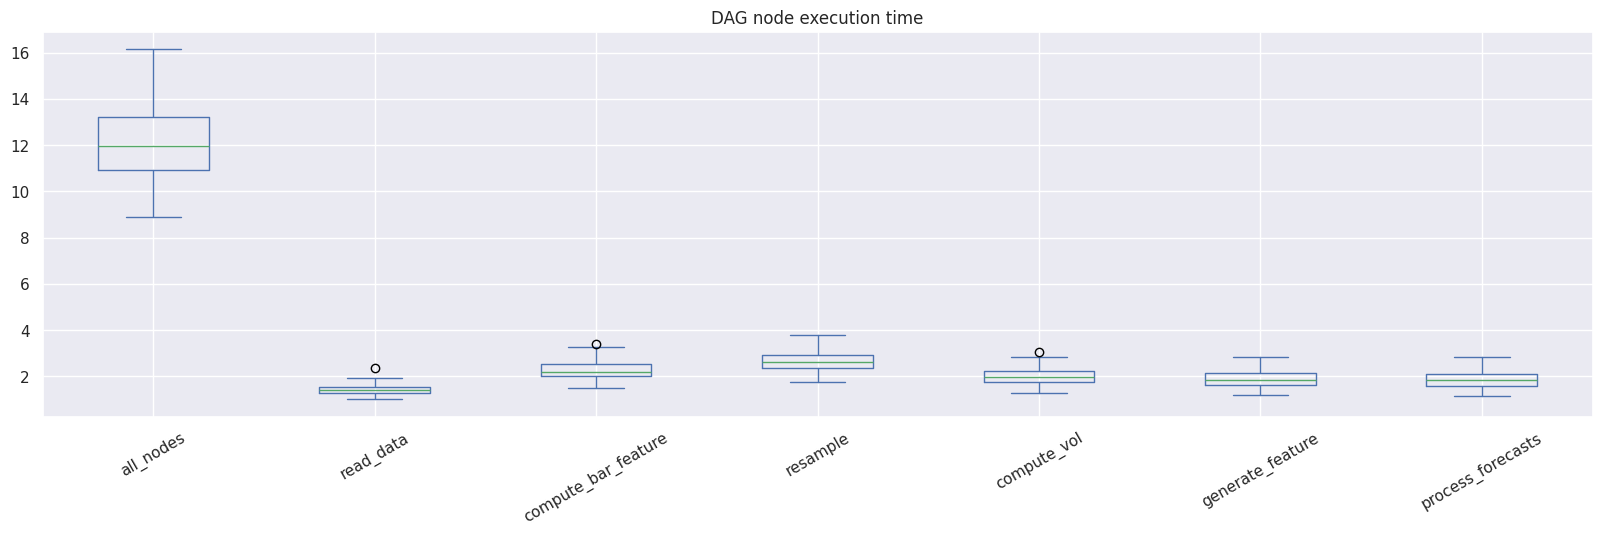

In [70]:
dtfcore.plot_dag_execution_stats(df_dag_execution_time, report_stats=True)

In [71]:
# The time is an approximation of how long it takes to process a bar. Technically the time
# is a distance (in secs) between wall clock time when an order is executed and a bar
# timestamp. The assumption is that order execution is the very last stage.
df_order_execution_time = dtfcore.get_orders_execution_time(
    orders_path_dict["prod"]
)
# TODO(Grisha): consider adding an assertion that checks that the time does not
# exceed one minute.
_LOG.info(
    "Max order execution time=%s secs",
    df_order_execution_time["execution_time"].max(),
)

INFO  Max order execution time=46 secs


# Compute DAG memory consumption

In [72]:
# Use a results df's size to measure memory consumption.
dag_df_out_size = dtfcore.get_dag_df_out_size_for_all_nodes(dag_path)
_LOG.info("DAG results df size:")
hpandas.df_to_str(dag_df_out_size, num_rows=5, log_level=logging.INFO)

INFO  DAG results df size:


read_data        compute_bar_feature        resample        compute_vol        generate_feature        process_forecasts       
                             n_cols n_rows              n_cols n_rows   n_cols n_rows      n_cols n_rows           n_cols n_rows            n_cols n_rows
2024-03-19 09:10:00-04:00       240     15                 264     15      192      3         264      3              288      3               288      3
2024-03-19 09:15:00-04:00       240     15                 264     15      192      3         264      3              288      3               288      3
                                ...    ...                 ...    ...      ...    ...         ...    ...              ...    ...               ...    ...
2024-03-20 09:00:00-04:00       240     15                 264     15      192      3         264      3              288      3               288      3
2024-03-20 09:05:00-04:00       240     15                 264     15      192      3         264      3              288      3               288      3

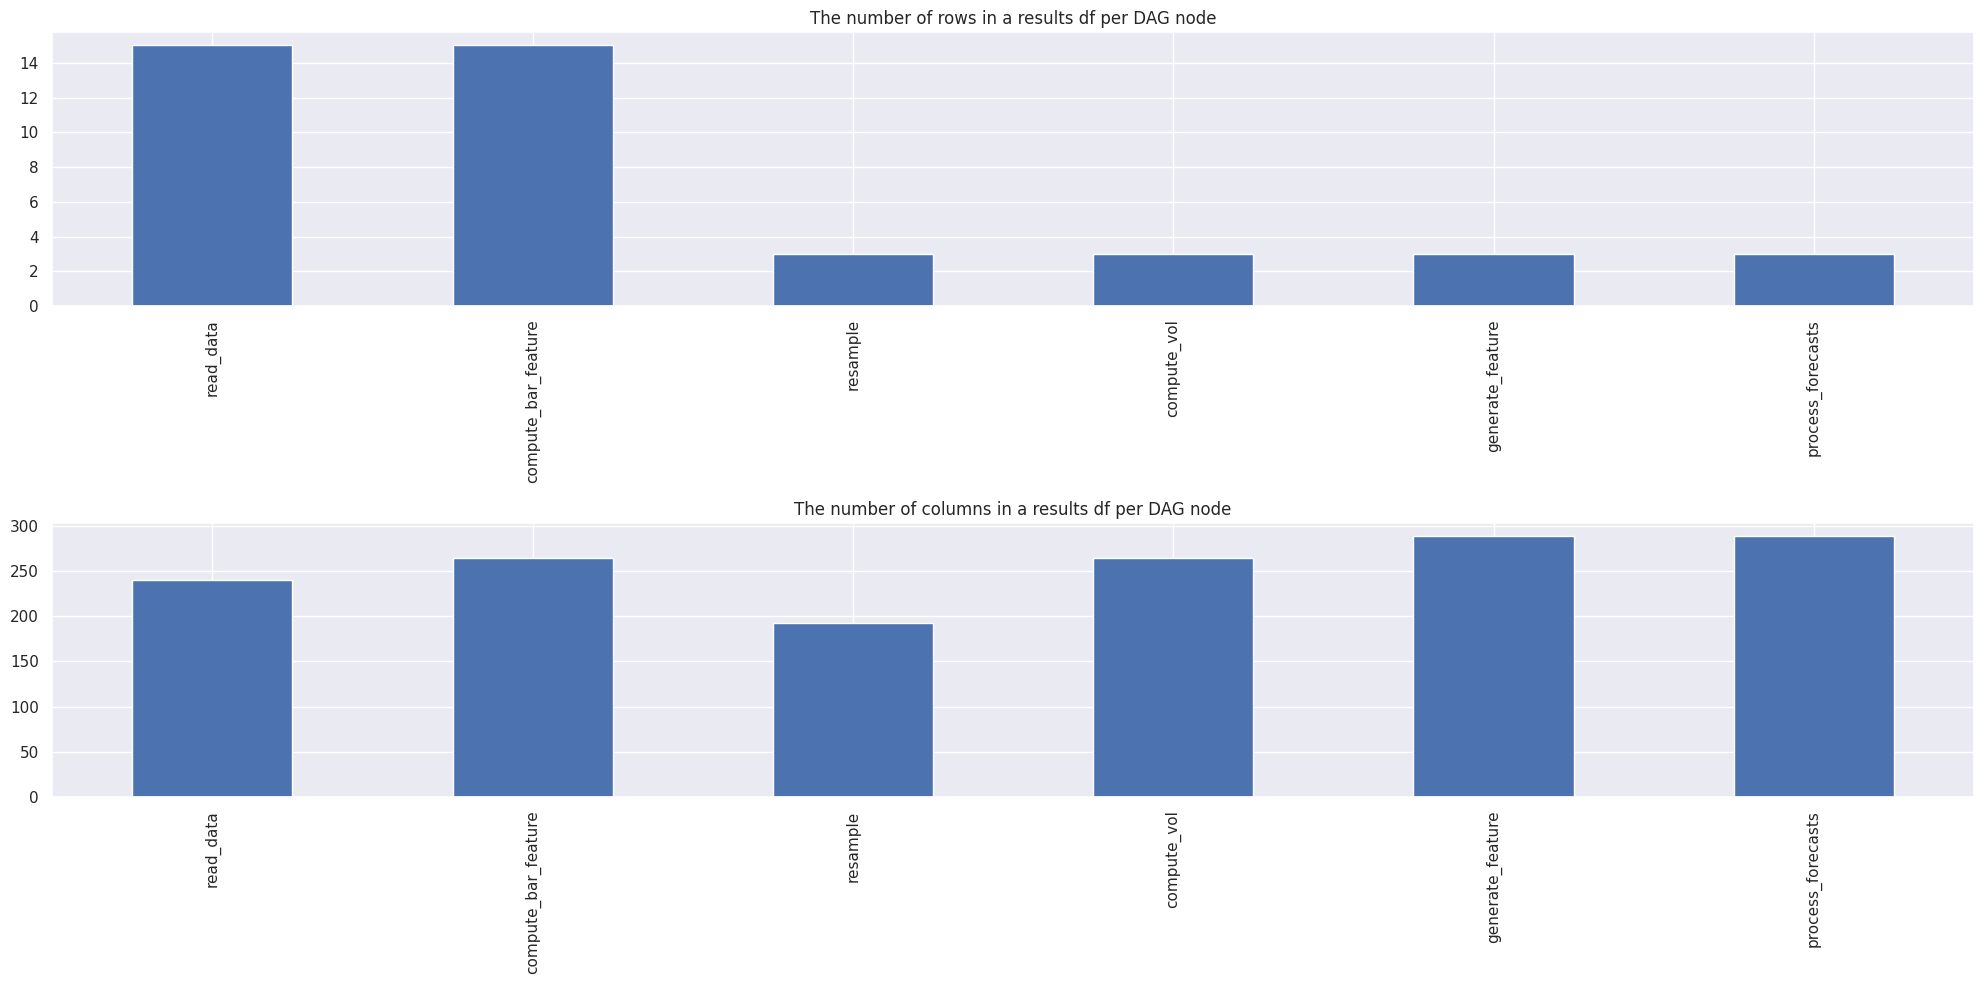

In [73]:
# Display the results df size distribution over the DAG nodes.
dtfcore.plot_dag_df_out_size_stats(dag_df_out_size, report_stats=False)

# Portfolio

## Compute research portfolio equivalent

In [74]:
# Set Portofolio start and end timestamps.
if True:
    # By default use the min/max bar timestamps from the DAG.
    start_timestamp = dag_node_timestamps[0][0]
    end_timestamp = dag_node_timestamps[-1][0]
else:
    # Overwrite if needed.
    start_timestamp = pd.Timestamp(
        "2022-11-03 06:05:00-04:00", tz="America/New_York"
    )
    end_timestamp = pd.Timestamp(
        "2022-11-03 08:00:00-04:00", tz="America/New_York"
    )
_LOG.info("start_timestamp=%s", start_timestamp)
_LOG.info("end_timestamp=%s", end_timestamp)

INFO  start_timestamp=2024-03-19 09:10:00-04:00
INFO  end_timestamp=2024-03-20 09:05:00-04:00


In [75]:
# Get forecast evaluator.
forecast_evaluator_type = config["forecast_evaluator_config"][
    "forecast_evaluator_type"
]
forecast_evaluator_kwargs = config["forecast_evaluator_config"]["init"]
forecast_evaluator = reconcil.get_forecast_evaluator_instance1(
    forecast_evaluator_type, forecast_evaluator_kwargs
)
#
annotate_forecasts_kwargs = config["forecast_evaluator_config"][
    "annotate_forecasts_kwargs"
].to_dict()
# Get dag data path for research portfolio.
compute_research_portfolio_mode = config["meta"][
    "compute_research_portfolio_mode"
]
computation_dag_path = reconcil.get_dag_output_path(
    dag_path_dict, compute_research_portfolio_mode
)
# Get computation dataframe for research portfolio.
research_portfolio_input_df = dtfcore.load_dag_outputs(
    computation_dag_path, dag_node_names[-1]
)
(
    research_portfolio_df,
    research_portfolio_stats_df,
) = forecast_evaluator.annotate_forecasts(
    research_portfolio_input_df,
    **annotate_forecasts_kwargs,
    compute_extended_stats=True,
)
# TODO(gp): Move it to annotate_forecasts?
research_portfolio_df = research_portfolio_df.sort_index(axis=1)
# Align index with prod and sim portfolios.
research_portfolio_df = research_portfolio_df.loc[start_timestamp:end_timestamp]
research_portfolio_stats_df = research_portfolio_stats_df.loc[
    start_timestamp:end_timestamp
]
#
hpandas.df_to_str(research_portfolio_stats_df, num_rows=5, log_level=logging.INFO)

/venv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1001) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  warnings.warn(


,pnl,gross_volume,net_volume,gmv,nmv,gpc,npc,wnl
2024-03-19 09:25:00-04:00,-2.312065,4271.929058,879.603383,3098.584463,532.436778,24.0,0.0,-1.0
2024-03-19 09:30:00-04:00,1.786862,3219.751884,-565.956705,2911.41402,-31.733066,23.0,-1.0,-2.0
,...,...,...,...,...,...,...,...
2024-03-20 09:00:00-04:00,-1.165174,3451.36374,186.215277,2957.56539,676.061164,23.0,1.0,-1.0
2024-03-20 09:05:00-04:00,-0.620561,2401.541823,-933.82689,2913.486489,-258.386287,23.0,-1.0,-1.0


## Load logged portfolios (prod & sim)

In [76]:
portfolio_dfs, portfolio_stats_dfs = reconcil.load_portfolio_dfs(
    portfolio_path_dict,
    config["meta"]["bar_duration"],
)
# Add research portfolio.
portfolio_dfs["research"] = research_portfolio_df
hpandas.df_to_str(portfolio_dfs["prod"], num_rows=5, log_level=logging.INFO)

INFO  Processing portfolio=prod path=/shared_data/CmTask7204_2/C3a/paper_trading/20240319_131000.20240320_130500/prod/system_log_dir.scheduled/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/288 [00:00<?, ?it/s]

INFO  Processing portfolio=sim path=/shared_data/CmTask7204_2/C3a/paper_trading/20240319_131000.20240320_130500/simulation/system_log_dir.scheduled/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/288 [00:00<?, ?it/s]

holdings_shares                                                                                                                                                                                                                                                              holdings_notional                                                                                                                                                                                                                                                                  executed_trades_shares                                                                                                                                                                                                                                                              executed_trades_notional                                                                                                                                                                                                                                                                         pnl                                                                                                                                                                                                                                                             
                               6051632686 8717633868 2540896331 1528092593 8968126878 1467591036 5115052901 3065029174 1891737434 3401245610 1464553467 1966583502 1030828978 2601760471 2683705052 9872743573 2484635488 2099673105 4516629366 2237530510 2425308589 1776791608 2384892553 5118394986        1030828978  1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510  2384892553 2425308589 2484635488 2540896331  2601760471 2683705052 3065029174 3401245610 4516629366 5115052901  5118394986 6051632686 8717633868 8968126878 9872743573             6051632686 8717633868 2540896331 1528092593 8968126878 1467591036 5115052901 3065029174 1891737434 3401245610 1464553467 1966583502 1030828978 2601760471 2683705052 9872743573 2484635488 2099673105 4516629366 2237530510 2425308589 1776791608 2384892553 5118394986               6051632686 8717633868 2540896331 1528092593 8968126878 1467591036 5115052901 3065029174 1891737434 3401245610  1464553467 1966583502 1030828978  2601760471 2683705052 9872743573 2484635488 2099673105 4516629366 2237530510 2425308589 1776791608  2384892553  5118394986 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573
2024-03-19 09:10:00-04:00             0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0               0.0         0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0         0.0        0.0        0.0        0.0         0.0        0.0        0.0        0.0        0.0        0.0         0.0        0.0        0.0        0.0        0.0                    0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0                      NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN         NaN        NaN        NaN         NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN         NaN         NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN     

In [77]:
# Add research df and combine into a single df.
portfolio_stats_dfs["research"] = research_portfolio_stats_df
portfolio_stats_df = pd.concat(portfolio_stats_dfs, axis=1)
#
hpandas.df_to_str(portfolio_stats_df, num_rows=5, log_level=logging.INFO)

prod                                                                                          sim                                                                                      research                                                                  
                               pnl gross_volume  net_volume          gmv         nmv        cash  net_wealth  leverage      pnl gross_volume  net_volume          gmv         nmv        cash  net_wealth  leverage       pnl gross_volume  net_volume          gmv         nmv   gpc  npc  wnl
2024-03-19 09:10:00-04:00      NaN          0.0         0.0          0.0         0.0       700.0       700.0       0.0      NaN          0.0         0.0          0.0         0.0       700.0       700.0       0.0       NaN          NaN         NaN          NaN         NaN   NaN  NaN  NaN
2024-03-19 09:15:00-04:00      0.0  2949.223844  181.271116  2949.223844  181.271116  518.728884       700.0  4.213177      0.0  2949.223844  181.271116  2949.223844  181.271116  518.728884       700.0  4.213177       NaN          NaN         NaN          NaN         NaN   NaN  NaN  NaN
                               ...          ...         ...          ...         ...         ...         ...       ...      ...          ...         ...          ...         ...         ...         ...       ...       ...          ...         ...          ...         ...   ...  ...  ...
2024-03-20 09:00:00-04:00 -1.09621  3442.670232  193.701096   2961.45403  680.996934   15.237718  696.234652  4.253529 -1.09621  3442.670232  193.701096   2961.45403  680.996934   15.237718  696.234652  4.253529 -1.165174   3451.36374  186.215277   2957.56539  676.061164  23.0  1.0 -1.0
2024-03-20 09:05:00-04:00 -0.99733   2392.36322 -943.940156  2909.022008 -263.940552  959.177874  695.237322  4.184214 -0.99733   2392.36322 -943.940156  2909.022008 -263.940552  959.177874  695.237322  4.184214 -0.620561  2401.541823  -933.82689  2913.486489 -258.386287  23.0 -1.0 -1.0

## Compute Portfolio statistics (prod vs research vs sim)

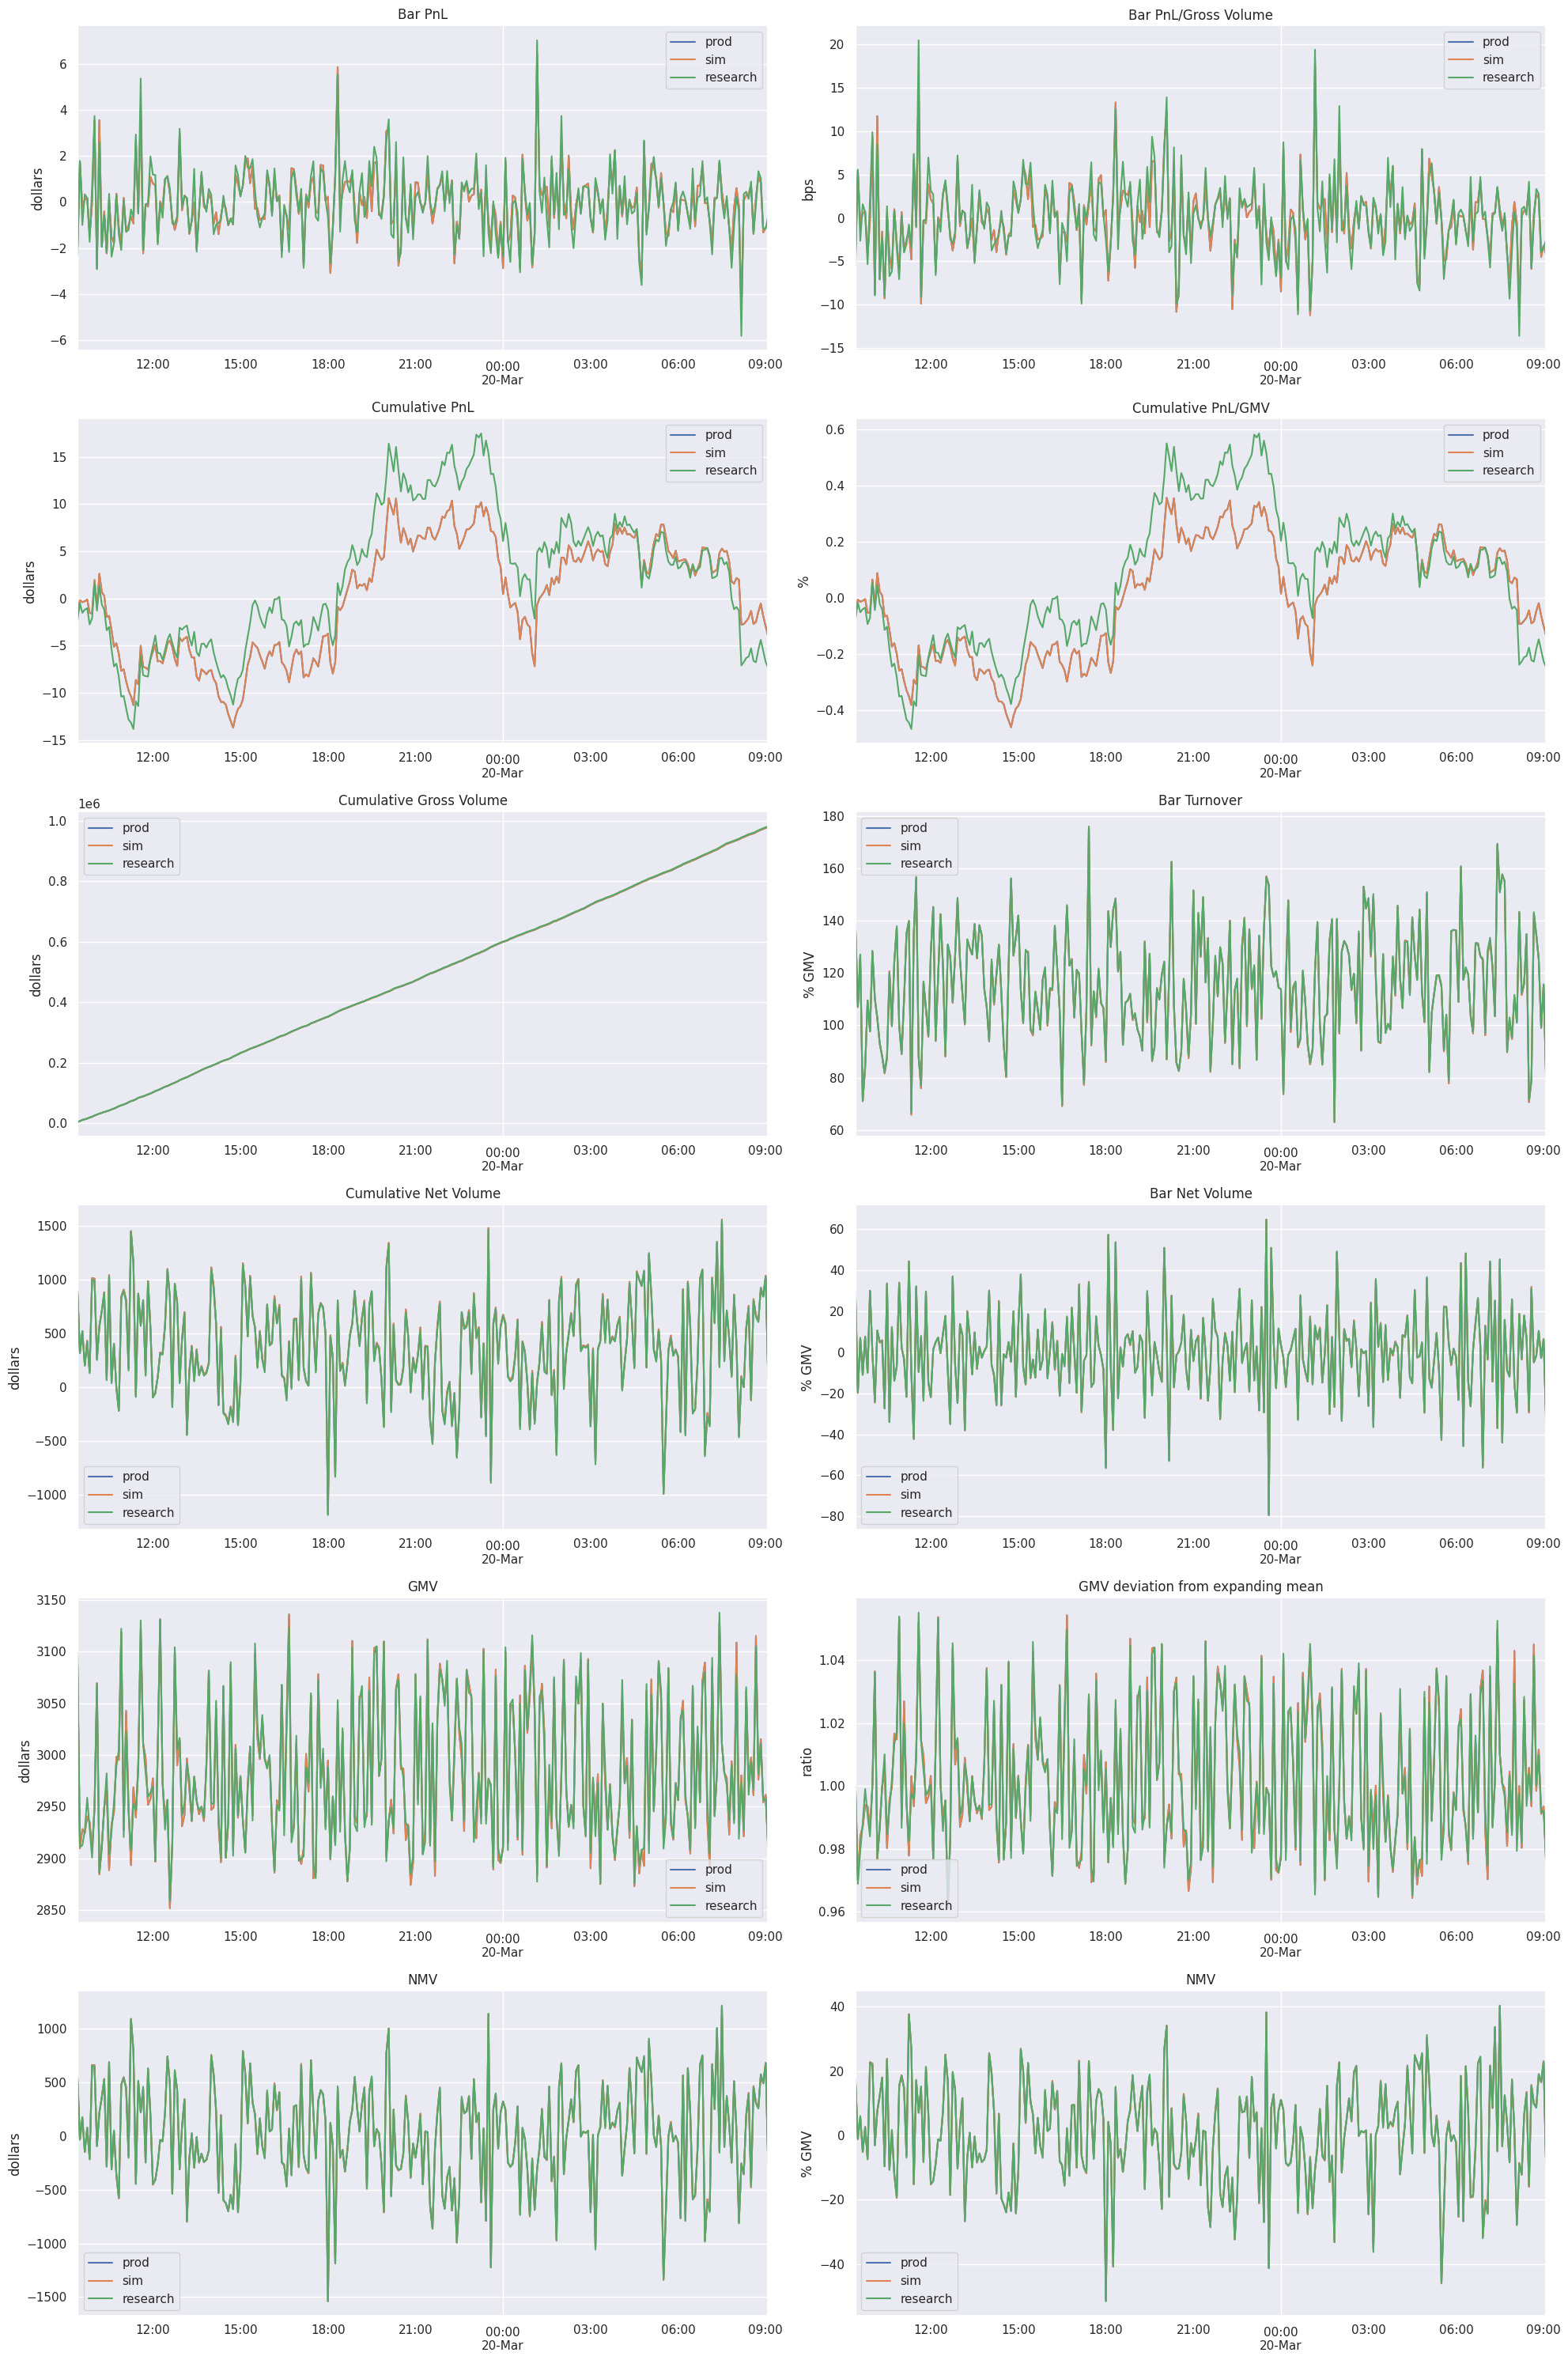

In [78]:
bars_to_burn = config["forecast_evaluator_config"]["annotate_forecasts_kwargs"][
    "burn_in_bars"
]
coplotti.plot_portfolio_stats(portfolio_stats_df.iloc[bars_to_burn:])

In [79]:
stats_computer = dtfmod.StatsComputer()
stats_sxs, _ = stats_computer.compute_portfolio_stats(
    portfolio_stats_df.iloc[bars_to_burn:], config["meta"]["bar_duration"]
)
display(stats_sxs)

prod      sim  research
ratios     sharpe_ratio                   -3.32    -3.32     -5.54
           sharpe_ratio_standard_error    19.24    19.24     19.24
           sr.tval                        -0.17    -0.17     -0.29
           sr.pval                         0.86     0.86      0.77
           kratio                         14.54    14.54      9.60
dollar     gmv_mean                     2980.54  2980.54   2980.93
           gmv_stdev                      67.33    67.33     67.02
           annualized_mean_return      -1462.57 -1462.57  -2708.11
           annualized_volatility         440.87   440.87    489.17
           max_drawdown                   17.81    17.81     24.83
           pnl_mean                       -0.01    -0.01     -0.03
           pnl_std                         1.36     1.36      1.51
           turnover_mean                3434.69  3434.69   3443.37
           turnover_stdev                624.97   624.97    623.37
           market_bias_mean               14.93    14.93     14.93
           market_bias_stdev             467.99   467.99    468.27
percentage annualized_mean_return        -49.07   -49.07    -90.85
           annualized_volatility          14.79    14.79     16.41
           max_drawdown                    0.60     0.60      0.83
           pnl_mean                       -0.00    -0.00     -0.00
           pnl_std                         0.05     0.05      0.05
           turnover_mean                 115.24   115.24    115.51
           turnover_stdev                 20.97    20.97     20.91
           market_bias_mean                0.50     0.50      0.50
           market_bias_stdev              15.70    15.70     15.71

## Compare portfolios pairwise (prod vs research vs sim)

### Differences

#### Prod vs sim

In [80]:
report_stats = False
display_plot = False
compare_dfs_kwargs = {
    "column_mode": "inner",
    "diff_mode": "pct_change",
    "remove_inf": True,
    "assert_diff_threshold": None,
}
portfolio_diff_df = reconcil.compare_portfolios(
    portfolio_dfs,
    report_stats=report_stats,
    display_plot=display_plot,
    **compare_dfs_kwargs,
)
hpandas.df_to_str(portfolio_diff_df, num_rows=None, log_level=logging.INFO)

WARNING * Failed assertion *
'0'
==
'3'
There are NaN values in one of the dataframes that are not in the other one.
Continuing as per user request with only_warning=True
WARNING * Failed assertion *
'0'
==
'3'
There are NaN values in one of the dataframes that are not in the other one.
Continuing as per user request with only_warning=True


,prod_research_diff,prod_sim_diff,research_sim_diff
executed_trades_notional.pct_change,2649.728096,0.0,96.363277
executed_trades_shares.pct_change,2650.000000,0.0,96.363636
holdings_notional.pct_change,142.561261,0.0,124.904248
holdings_shares.pct_change,142.857143,0.0,125.000000
pnl.pct_change,222661.974657,0.0,6598.321322


### Correlations

#### Prod vs sim

In [81]:
if False:
    dtfmod.compute_correlations(
        portfolio_dfs["prod"],
        portfolio_dfs["sim"],
        allow_unequal_indices=False,
        allow_unequal_columns=False,
    )

#### Prod vs research

In [82]:
if False:
    dtfmod.compute_correlations(
        research_portfolio_df,
        portfolio_dfs["prod"],
        allow_unequal_indices=True,
        allow_unequal_columns=True,
    )

#### Sim vs research

In [83]:
if False:
    dtfmod.compute_correlations(
        research_portfolio_df,
        portfolio_dfs["sim"],
        allow_unequal_indices=True,
        allow_unequal_columns=True,
    )

# Target positions

## Load target positions (prod)

In [84]:
prod_target_position_df = reconcil.load_target_positions(
    portfolio_path_dict["prod"].strip("portfolio"),
    config["meta"]["bar_duration"],
)
hpandas.df_to_str(prod_target_position_df, num_rows=5, log_level=logging.INFO)
if False:
    # TODO(Grisha): compare prod vs sim at some point.
    sim_target_position_df = reconcil.load_target_positions(
        portfolio_path_dict["sim"].strip("portfolio"),
        config["meta"]["bar_duration"],
    )

Loading `target_positions` files...:   0%|          | 0/288 [00:00<?, ?it/s]

holdings_shares                                                                                                                                                                                                                                                                   price                                                                                                                                                                                                                                                              holdings_notional                                                                                                                                                                                                                                                                  prediction                                                                                                                                                                                                                                                              volatility                                                                                                                                                                                                                                                                  spread                                                                                                                                                                                                                                                              target_holdings_notional                                                                                                                                                                                                                                                                   target_trades_notional                                                                                                                                                                                                                                                                  target_trades_shares                                                                                                                                                                                                                                                              target_holdings_shares                                                                                                                                                                                                                                                              target_holdings_shares.before_apply_cc_limits                                                                                                                                                                                                                                                              target_holdings_notional.before_apply_cc_limits                                                                                                                                                                                                                                                                   target_trades_shares.before_apply_cc_limits                                                                                                                                                                                                                                                              target_trades_notional.before_apply_cc_limits                                                                                                                                                                                                                                                                 
asset_id                       1030828978 1464553467 1467591036 1528092593 1776791

## Compare positions target vs executed (prod)

In [85]:
# TODO(Grisha): use `hpandas.compare_dfs()`.
df1 = prod_target_position_df["target_holdings_shares"].shift(1)
df2 = prod_target_position_df["holdings_shares"]
diff = df1 - df2
hpandas.df_to_str(diff, num_rows=5, log_level=logging.INFO)

asset_id,1030828978,1464553467,1467591036,1528092593,1776791608,1891737434,1966583502,2099673105,2237530510,2384892553,2425308589,2484635488,2540896331,2601760471,2683705052,3065029174,3401245610,4516629366,5115052901,5118394986,6051632686,8717633868,8968126878,9872743573
2024-03-19 09:10:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-19 09:15:00-04:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-20 09:00:00-04:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-03-20 09:05:00-04:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Compare target positions (prod vs research)

### Price

In [86]:
# TODO(Grisha): wrap in a function since it's common for all columns.
column = "price"
prod_df = prod_target_position_df[column]
res_df = research_portfolio_df[column]

# Compute percentage difference.
diff_df = hpandas.compare_dfs(
    prod_df,
    res_df,
    diff_mode="pct_change",
    # Some pipelines (e.g., "C8b") do not use "close" prices to compute
    # "twap" / "vwap". While when computing target positions "close"
    # prices from MarketData are used. Thus the perfect match is not
    # expected.
    assert_diff_threshold=None,
)
# Remove the sign and NaNs.
diff_df = diff_df.abs()
# Check that data is the same.
print(diff_df.max().max())
if False:
    hpandas.heatmap_df(diff_df.round(2))

0.6138486096262068


### Volatility

In [87]:
column = "volatility"
prod_df = prod_target_position_df[column]
res_df = research_portfolio_df[column]

# Compute percentage difference.
diff_df = hpandas.compare_dfs(
    prod_df,
    res_df,
    diff_mode="pct_change",
)
# Remove the sign and NaNs.
diff_df = diff_df.abs()
# Check that data is the same.
print(diff_df.max().max())
if False:
    hpandas.heatmap_df(diff_df.round(2))

1.6674513594791735e-11


### Prediction

In [88]:
column = "prediction"
prod_df = prod_target_position_df[column]
res_df = research_portfolio_df[column]

# Compute percentage difference.
diff_df = hpandas.compare_dfs(
    prod_df,
    res_df,
    diff_mode="pct_change",
)
# Remove the sign and NaNs.
diff_df = diff_df.abs()
# Check that data is the same.
print(diff_df.max().max())
if False:
    hpandas.heatmap_df(diff_df.round(2))

4.0303698427338605e-11


### Current holdings

In [89]:
column = "holdings_shares"
prod_df = prod_target_position_df[column]
res_df = research_portfolio_df[column]

# Compute percentage difference.
diff_df = hpandas.compare_dfs(
    prod_df,
    res_df,
    diff_mode="pct_change",
    assert_diff_threshold=None,
)
# Remove the sign and NaNs.
diff_df = diff_df.abs()
# Check that data is the same.
print(diff_df.max().max())
if False:
    hpandas.heatmap_df(diff_df.round(2))

WARNING * Failed assertion *
'0'
==
'3'
There are NaN values in one of the dataframes that are not in the other one.
Continuing as per user request with only_warning=True
142.85714285714286


### Target holdings

In [90]:
prod_df = prod_target_position_df["target_holdings_shares"].shift(1)
res_df = research_portfolio_df["holdings_shares"]

# Compute percentage difference.
diff_df = hpandas.compare_dfs(
    prod_df,
    res_df,
    diff_mode="pct_change",
    assert_diff_threshold=None,
)
# Remove the sign and NaNs.
diff_df = diff_df.abs()
# Check that data is the same.
print(diff_df.max().max())
if False:
    hpandas.heatmap_df(diff_df.round(2))

WARNING * Failed assertion *
'0'
==
'2'
There are NaN values in one of the dataframes that are not in the other one.
Continuing as per user request with only_warning=True
142.85714285714286


# Orders

## Load orders (prod & sim)

In [91]:
prod_order_df = oms.TargetPositionAndOrderGenerator.load_orders(
    portfolio_path_dict["prod"].strip("portfolio"),
)
hpandas.df_to_str(prod_order_df, num_rows=5, log_level=logging.INFO)
sim_order_df = oms.TargetPositionAndOrderGenerator.load_orders(
    portfolio_path_dict["sim"].strip("portfolio"),
)
hpandas.df_to_str(sim_order_df, num_rows=5, log_level=logging.INFO)

Loading `orders` files...:   0%|          | 0/288 [00:00<?, ?it/s]

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params
0,2024-03-19 09:10:26.452897-04:00,6051632686,price@twap,2024-03-19 09:10:26.452897-04:00,2024-03-19 09:15:00-04:00,0.0,35.0,America/New_York,{}
1,2024-03-19 09:10:26.452897-04:00,8717633868,price@twap,2024-03-19 09:10:26.452897-04:00,2024-03-19 09:15:00-04:00,0.0,1.0,America/New_York,{}
,...,...,...,...,...,...,...,...,...
6095,2024-03-20 09:05:45.575258-04:00,8968126878,price@twap,2024-03-20 09:05:45.575258-04:00,2024-03-20 09:10:00-04:00,0.2,0.09,America/New_York,{}
6096,2024-03-20 09:05:45.575258-04:00,9872743573,price@twap,2024-03-20 09:05:45.575258-04:00,2024-03-20 09:10:00-04:00,-17.0,21.0,America/New_York,{}


Loading `orders` files...:   0%|          | 0/288 [00:00<?, ?it/s]

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params
0,2024-03-19 09:10:10.100000-04:00,6051632686,price@twap,2024-03-19 09:10:10.100000-04:00,2024-03-19 09:15:00-04:00,0.0,35.0,America/New_York,{}
1,2024-03-19 09:10:10.100000-04:00,8717633868,price@twap,2024-03-19 09:10:10.100000-04:00,2024-03-19 09:15:00-04:00,0.0,1.0,America/New_York,{}
,...,...,...,...,...,...,...,...,...
6095,2024-03-20 09:05:10.100000-04:00,8968126878,price@twap,2024-03-20 09:05:10.100000-04:00,2024-03-20 09:10:00-04:00,0.2,0.09,America/New_York,{}
6096,2024-03-20 09:05:10.100000-04:00,9872743573,price@twap,2024-03-20 09:05:10.100000-04:00,2024-03-20 09:10:00-04:00,-17.0,21.0,America/New_York,{}


## Compare orders (prod vs sim)

In [92]:
# TODO(Grisha): add comparison using the usual `pct_change` approach.

# Compute execution quality

In [93]:
(
    execution_quality_df,
    execution_quality_stats_df,
) = cftpdp.compute_execution_quality_df(
    portfolio_dfs["prod"],
    prod_target_position_df,
)
hpandas.df_to_str(execution_quality_df, num_rows=5, log_level=logging.INFO)
hpandas.df_to_str(execution_quality_stats_df, num_rows=5, log_level=logging.INFO)

executed_trades_shares                                                                                                                                                                                                                                                               fill_rate                                                                                                                                                                                                                                                              underfill_share_count                                                                                                                                                                                                                                                              underfill_notional                                                                                                                                                                                                                                                              underfill_opportunity_cost_realized_notional                                                                                                                                                                                                                                                              underfill_opportunity_cost_notional                                                                                                                                                                                                                                                              tracking_error_shares                                                                                                                                                                                                                                                              tracking_error_notional                                                                                                                                                                                                                                                              tracking_error_bps                                                                                                                                                                                                                                                                  is_buy                                                                                                                                                                                                                                                                 is_sell                                                                                                                                                                                                                                                              is_benchmark_profitable                                                                                                                                                                                                                                                              holdings_price_per_share                                                                                                                                                                                                                                                              trade_price_per_share                                                                                                                                                                                                                                                              slippage_notional                                                                                                                               

,slippage_notional,underfill_opportunity_cost_realized_notional,pnl,gross_volume,net_volume,gmv,nmv
2024-03-19 09:10:00-04:00,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2024-03-19 09:15:00-04:00,-0.0,NaN,0.0,2949.223844,181.271116,2949.223844,181.271116
,...,...,...,...,...,...,...
2024-03-20 09:00:00-04:00,-0.0,0.0,-1.09621,3442.670232,193.701096,2961.45403,680.996934
2024-03-20 09:05:00-04:00,-0.0,0.0,-0.99733,2392.36322,-943.940156,2909.022008,-263.940552


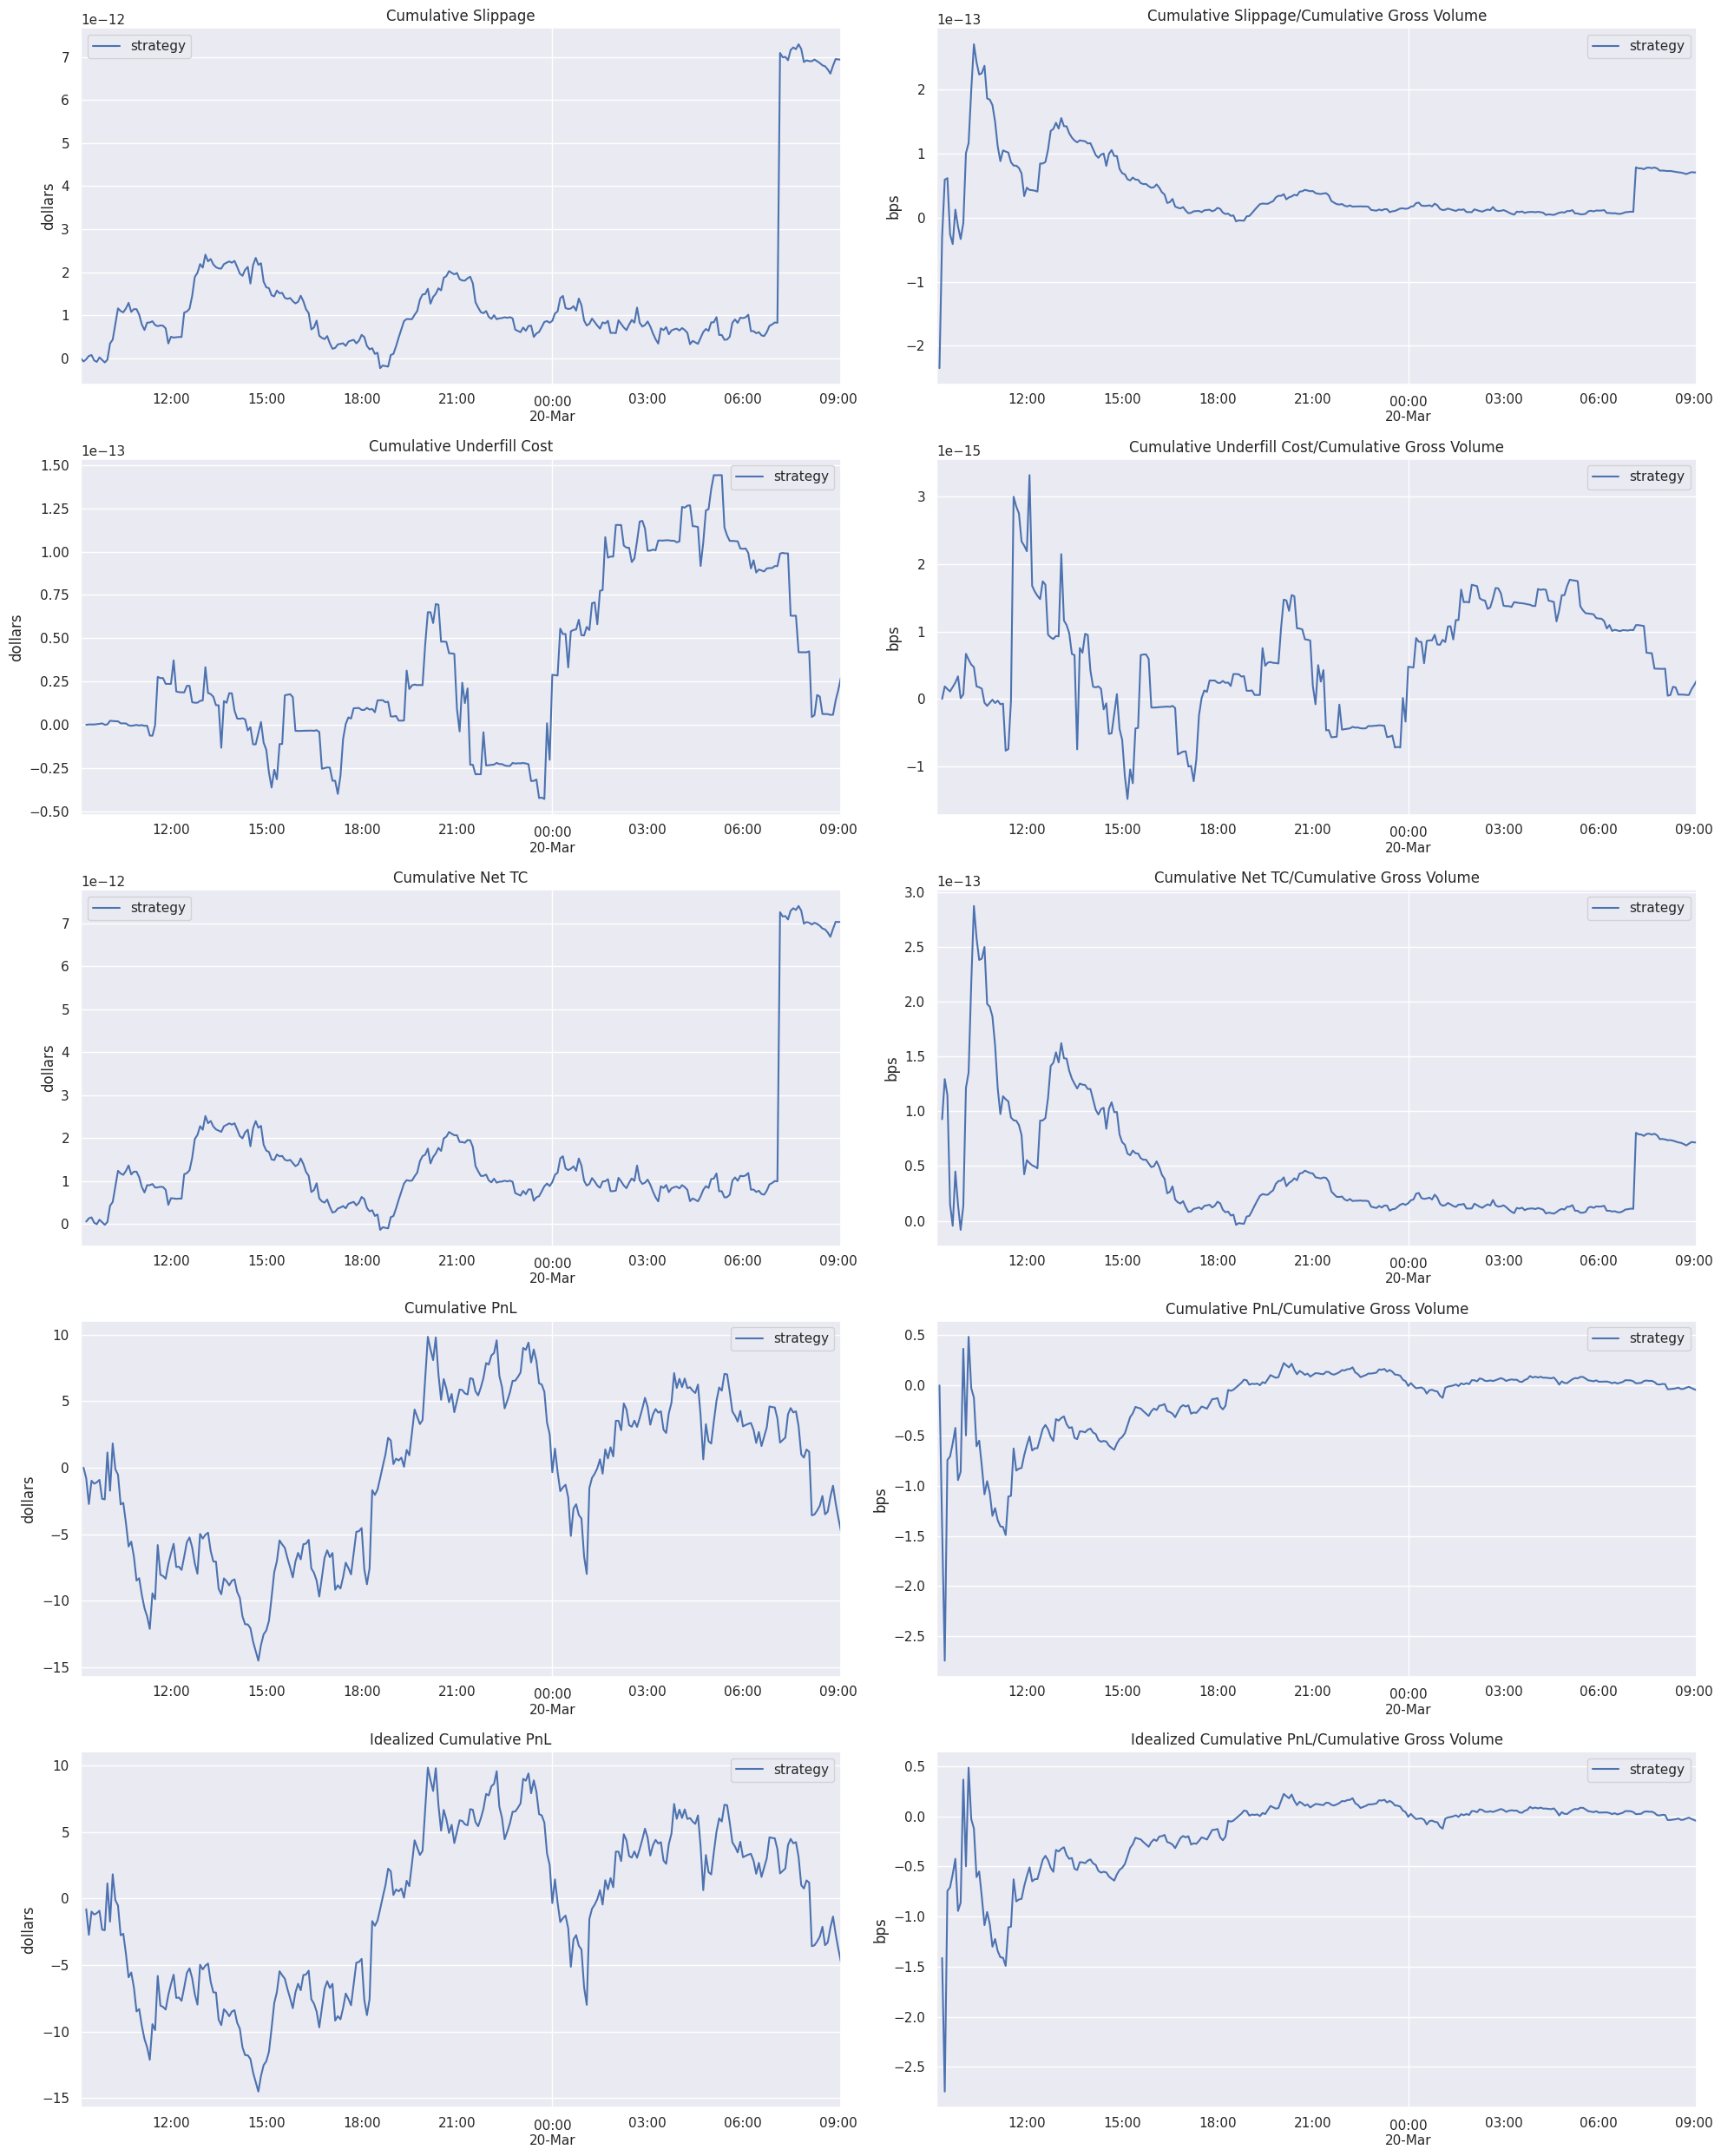

In [94]:
coplotti.plot_execution_stats(execution_quality_stats_df)

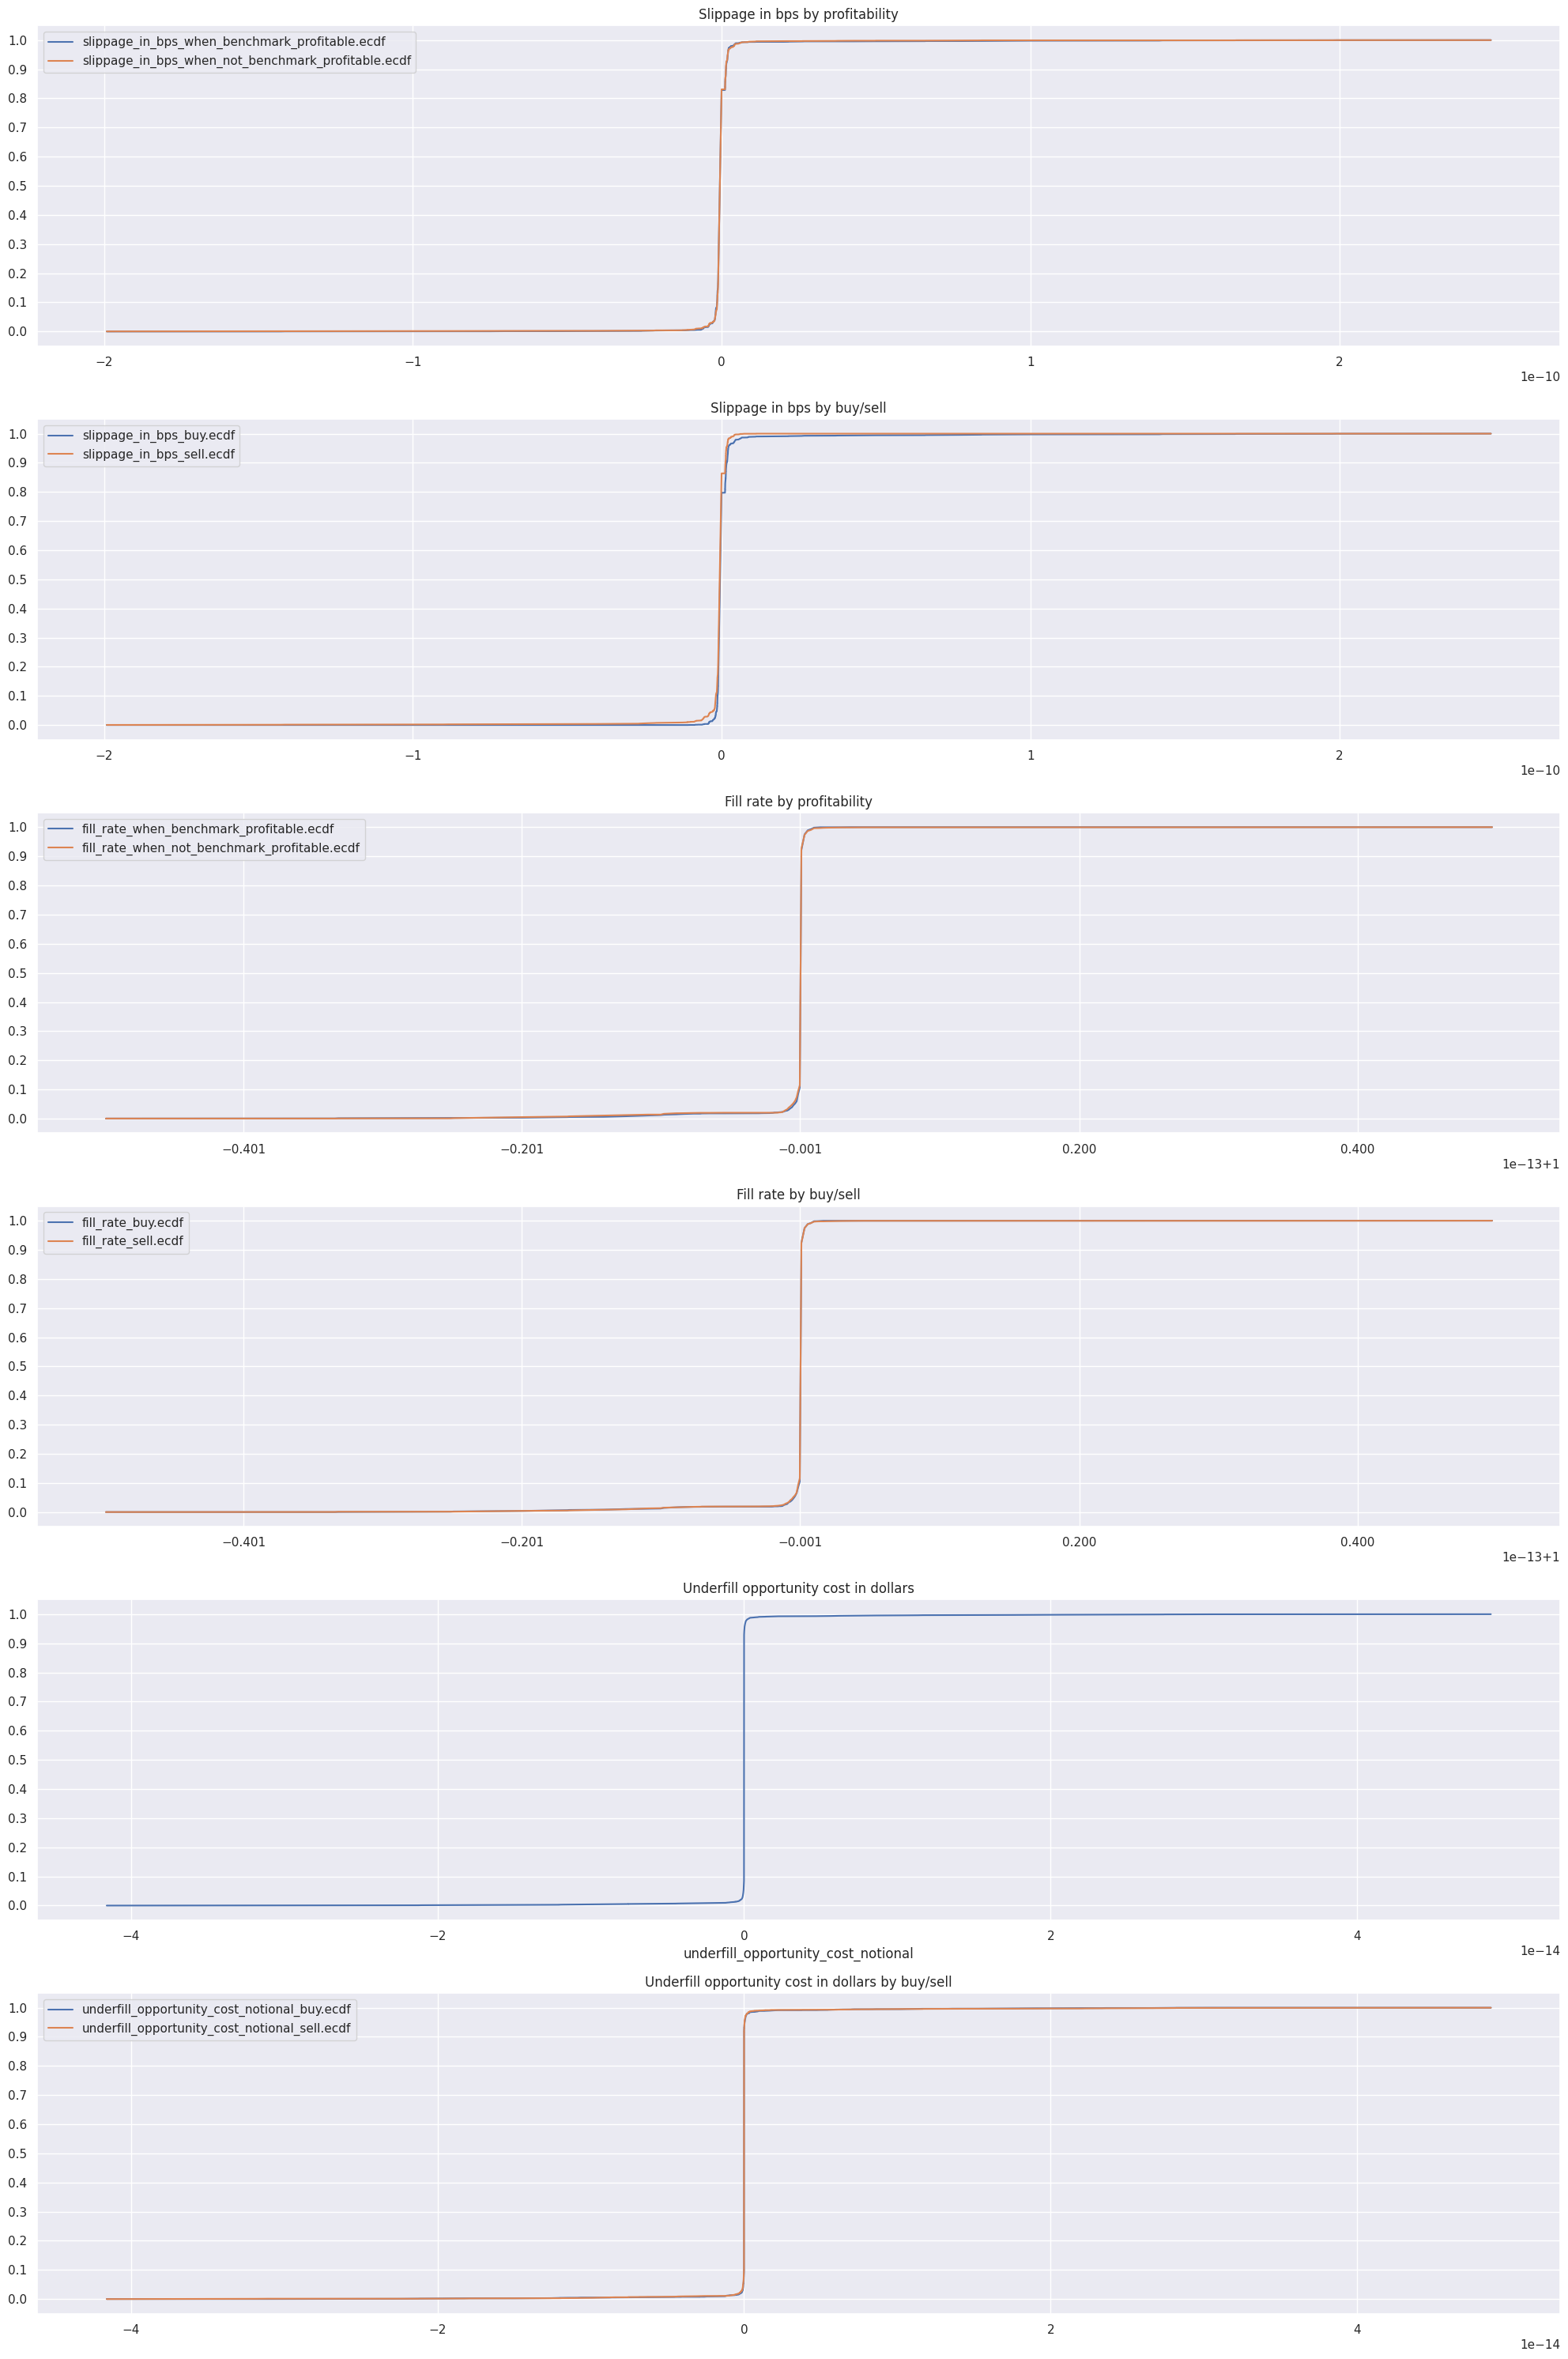

In [95]:
coplotti.plot_execution_ecdfs(execution_quality_df)